# Benchmarking Apache Spark IO

In this notebook we look at the Apache Spark performance in reading, decoding and distributing data from various data formats: CSV, FITS, and PARQUET. 

Author: Julien Peloton

### Using a pyspark notebook on a cluster

In order to launch this notebook from a cluster:

```bash
PYSPARK_DRIVER_PYTHON_OPTS="/opt/anaconda/bin/jupyter-notebook --no-browser --port=24500" pyspark \ 
    --master spark://134.158.75.222:7077 \
    --driver-memory 4g --executor-memory 28g \
    --executor-cores 17 --total-executor-cores 153 \
    --packages com.github.astrolabsoftware:spark-fits_2.11:0.6.0
```

Just adapt the port number, the master URL, and the resources to yours. Note that you need [spark-fits](https://github.com/astrolabsoftware/spark-fits) to process natively FITS with Apache Spark (just link using `--packages`).

In [8]:
from pyspark.sql import SparkSession

# Get our Spark Session active
spark = SparkSession.builder.getOrCreate()

### Useful routines: loading data from a distributed file system

In [77]:
# Define useful routines for later
from pyspark.sql import DataFrame

def load_data_from_hdfs(file_path: str, extension: str) -> DataFrame:
    """ Make a DataFrame with data stored on HDFS.
    The options used to load the data depend on the data format.
    
    Parameters
    ----------
    file_path : str
        URI to the data.
    extension : str
        File extension, e.g. 'fits', or 'parquet'.
        
    Returns
    ----------
    spark.sql DataFrame, with 3 columns.
    
    """
    # Common syntax for all format
    df_no_option = spark.read.format(extension)
    
    # format-specific options
    if extension == "fits":
        df_w_options = df_no_option.option("hdu", 1)
    elif extension == "csv" or extension == "json":
        df_w_options = df_no_option.option("header", True)
    elif extension == "parquet":
        df_w_options = df_no_option

    # Path to the data
    df = df_w_options.option("columns", "RA,Dec,Z_COSMO").load(file_path)
    
    return df

def replicate_dataset(
        df: DataFrame, file_path: str, extension: str, 
        replication: int, count: int=0) -> DataFrame:
    """
    Artificially increase the size of the DataFrame `df` by
    adding replication to it.

    Parameters
    ----------
    df : DataFrame
        The initial DataFrame
    file_path : str
        The path to the dataset to add
    extension : str
        File extension: csv, fits, parquet, etc.
    replication : int
        Number of replication to artificially increase the size of it.
        Note that a DataFrame union is performed under the hood. 
        A replication of 0 returns the initial DataFrame.
    count : int, optional
        Internal counter used for the recursion.

    Returns
    ----------
    df2 : DataFrame
        A DataFrame made of df + df_rep x numit.

    """
    if count == replication:
        return df
    else:
        df2 = load_data_from_hdfs(file_path, extension).union(df)
        return replicate_dataset(
            df2, file_path, extension, replication, count + 1)


## Benchmarking the performances

We loop over the different file format (FITS, PARQUET, CSV), and for each we load and decode the data stored on the distributed file system and we distribute it over the machines. Finally we count the total number of objects loaded. We record the total time to execute these operations.

In addition, once the data is loaded the first time, we keep it in-memory such that the later calls are performed faster. This is one of Spark's advantage over Hadoop's traditional MapReduce for example.

In [58]:
import os
from time import time
from pyspark import StorageLevel

# Parameters - to be changed by the user!

# Available file extensions
extensions = ["fits", "parquet", "csv"]

# Where the data is?
uri_base = "hdfs://134.158.75.222:8020//user/julien.peloton"

# Number of loops to perform (MC)
nloop = 100

# How many DataFrame to add 
replication = 9

# Should we keep the data in-memory after loading it?
in_memory = True

# Looping over the different data format
rdds = []
for extension in extensions:
    # Load the data
    fn = os.path.join(uri_base, "LSST1Y{}".format(extension.upper()))
    df = load_data_from_hdfs(fn, extension)

    # Replicate if needed
    df = replicate_dataset(df, fn, extension, replication)

    # Cache the data if needed
    if in_memory:
        df = df.persist(StorageLevel.MEMORY_ONLY_SER)

    times = []
    for index in range(nloop):
        # Loop over iterations
        t0 = time()
        result = df.count()
        t1 = time()
        # Note you would keep a trailing comma
        # for a single element.
        times.append((t1-t0, result))
    rdds.append(spark.sparkContext.parallelize(times))

### Visualise the result

Text(0.5,0,'time (second)')

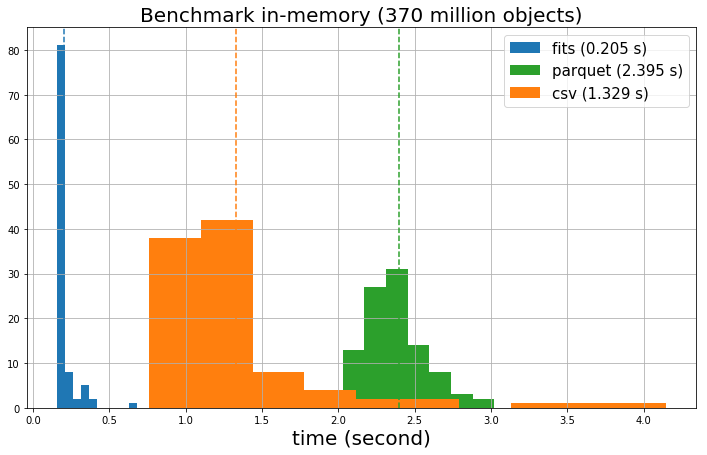

In [76]:
from pyspark.sql.types import *
import pylab as pl

colors = {"fits": "C0", "csv": "C1", "parquet": "C2"}

# Loop over the RDD
for index, (extension, rdd) in enumerate(zip(extensions, rdds)):
    colname = "Times from {}".format(extension)
    
    # Build a DataFrame from the RDD
    # We need to specify the schema
    schema = StructType([
        StructField(colname, DoubleType(), True),
        StructField("Count", LongType(), True)])
    df_times = rdd.toDF(schema).toPandas()
    mean = df_times[1:].mean()[colname]
    
    # Plot the data as histogram
    if index == 0:    
        ax = df_times[1:].hist(
            colname,
            label=extension + " ({:.3f} s)".format(mean),
            figsize=(12, 7),
            color=colors[extension])
    else:
        df_times[1:].hist(
            colname,
            ax=ax,
            label=extension + " ({:.3f} s)".format(mean),
            color=colors[extension])

    # Add the mean of each distribution
    pl.axvline(mean, color=colors[extension], ls='--')

pl.legend(fontsize=15)
pl.title("Benchmark in-memory (370 million objects)", fontsize=20)
pl.xlabel("time (second)", fontsize=20)

**Caption**: Per-iteration running time for each of the data format to load and read a data set with 370 million galaxies (RA, Dec, Z): FITS (blue), PARQUET (green) and CSV (orange).
We show only the timing once the data reside in-memory (that is for 1 < iteration < 100).
In the legend, the numbers in parenthesis are the means of each distribution.
This run has been performed on a dedicated cluster installed at Université Paris-Sud, Cloud@VirtualData, France with 9 Spark executors (machines), each having 17 cores and 30 gigabytes (GB) of RAM total. The amount of memory dedicated to the caching of data is 162 GB across the cluster. We use a HDFS cluster for storage with 9 DataNotes, each of 3.9 terabytes (TB), and with 128 megabytes (MB) file block size.